In [623]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [624]:
import os, pathlib
FILE_DIR = os.getcwd()

# Fuel Types
FUEL = ['natural gas', 'geothermal', 'nuclear', 'hydro', 'wind', 'solar', 'other']
NUMFT = len(FUEL)

# NREL LCA (Life Cycle Assessment) CO2 Emissions in metric tons per MWh for each fuel type 
E = np.array([0.49, 0.038, 0.012, 0.024, 0.012, 0.048, 0.23])

EMISSION_FACTORS = {
    'natural gas':   1.49,     # ← replace with your numbers
    'geothermal':    0.038,
    'nuclear':    0.012,
    'hydro':  0.024,
    'wind':   0.012,
    'solar':  0.048,
    # … add any other technologies you model
}
# LCOE in $/MWh for each fuel type from AEO2023
C = np.array([42.72, 37.30, 71.00, 57.12, 31.07, 23.22, 77.16])

# State level data on population, energy demand, current co2 emissions from electricity
FNAME = os.path.join(FILE_DIR, "StateData.xlsx")
STATES = pd.read_excel(FNAME, sheet_name="StateData", index_col=0, header=0)

# CAISO (Aug 2025) installed generation capacity for the state (in MW)
INSTALLED_CAPACITY_MW = {
    'natural gas': 50_000,
    'geothermal': 1_900,
    'nuclear': 2_300,
    'hydro': 5_000,
    'wind': 6_300,
    'solar': 20_000,
    'other': 15_000
}
INSTALLED_CAPACITY_MW_original = {
    'coal': 20_000,
    'NGCC': 4_600+2_160, # plus imports are 2_160
    'nuclear': 2_300,
    'hydro': 2_600,
    'wind': 4_000,
    'solar': 10_000,
}
INSTALLED_CAPACITY_MW_array = np.array([INSTALLED_CAPACITY_MW[f] for f in FUEL])

In [625]:
### DATA PREPARATION FOR HOURLY MODEL ###

# Number of time steps in our model (24 hours)
T = 24
hours = np.arange(T)

# 1. Simulate the Demand for a representative day
# This curve shows high demand in the morning and a sharp ramp-up in the evening,
# with a dip in the middle of the day.
# Normalize to 1.0 as peak within a day
# https://engaging-data.com/california-electricity-generation/
demand_curve_normalized = np.array([
    0.74, 0.7, 0.67, 0.65, 0.64, 0.66, 0.70, 0.73, # Morning
    0.73, 0.72, 0.7, 0.68, 0.68, 0.69, 0.74, 0.79, # Afternoon
    0.86, 0.91, 0.97, 1.00, 0.98, 0.95, 0.91, 0.84  # Evening Peak
])

demand_curve_normalized_original = np.array([
    0.60, 0.58, 0.57, 0.56, 0.57, 0.61, 0.70, 0.75, # Morning
    0.76, 0.77, 0.77, 0.78, 0.78, 0.80, 0.82, 0.86, # Afternoon
    0.88, 0.9, 0.95, 1.00, 0.98, 0.90, 0.80, 0.70  # Evening Peak
])

duck_curve_normalized_original = np.array([
    0.60, 0.58, 0.57, 0.56, 0.57, 0.61, 0.70, 0.75, # Morning
    0.65, 0.55, 0.45, 0.38, 0.35, 0.33, 0.35, 0.45, # Midday "Belly"
    0.60, 0.80, 0.95, 1.00, 0.98, 0.90, 0.80, 0.70  # Evening Peak
])

# 2. Define Hourly Capacity Factors (AEO2023)
# Solar only works during the day. Wind might be stronger at night.
# Dispatchable generation (Coal, NGCC, Nuclear) is assumed to be available 24/7.
HRLY_CAP_FACTORS = pd.DataFrame(index=FUEL, columns=hours, data=1.0) # Default to 100% available
HRLY_CAP_FACTORS.loc['solar'] = [0, 0, 0, 0, 0, 0, 0.3, 0.3,
                                 0.77, 0.89, 0.96, 1.0, 1.0, 1, 1, 1,
                                 0.96, 0.92, 0.78, 0.3, 0.02, 0, 0, 0]
HRLY_CAP_FACTORS.loc['wind']  = [0.5, 0.52, 0.53, 0.51, 0.48, 0.45, 0.42, 0.43,
                                 0.45, 0.4, 0.35, 0.3, 0.28, 0.30, 0.32, 0.35,
                                 0.4, 0.45, 0.5, 0.55, 0.6, 0.58, 0.55, 0.52]


# 3. Define Battery Bank Parameters
EVC_MAX = 80/1e3 # convert to MWh
EVS = 1.08e6 # Summation of all counties in service area from predictive model (15087)
BATTERY_MAX_ENERGY_MWH = EVC_MAX*EVS
BATTERY_MAX_POWER_MW = BATTERY_MAX_ENERGY_MWH / 16 # Max charge/discharge rate (C/4 rate)
BATTERY_CHARGE_EFFICIENCY = 0.95 # 95% efficiency when charging
BATTERY_INITIAL_SOC_MWH = BATTERY_MAX_ENERGY_MWH / 2 # Start the day at 50% charge

# 4. Define Optimization Parameters
state = 'CA'
futureDemandGrowth = 1.0 # Future electricity demand as pct of current
futureCo2Improve = 1 # Future emissions target as pct of current

daily_demand_mwh = STATES['Demand (MWh)'][state] * futureDemandGrowth / 365
HRLYDEMAND = demand_curve_normalized * daily_demand_mwh / demand_curve_normalized.sum()
daily_co2_limit = STATES['CO2 Emissions (million metric tons)'][state]*1e6*futureCo2Improve/365
print(daily_co2_limit)

95068.49315068492


In [626]:
def solve_with_capacity(capacity_dict, optimize_cost=True):
    """Build and solve a fresh dispatch model, return the objective value ($)."""
    INSTALLED = copy.deepcopy(capacity_dict)          # never mutate caller’s dict
    INSTALLED_array = np.array([INSTALLED[f] for f in FUEL])
    ### --- OPTIMIZATION MODEL WITH BATTERIES --- ###

    # Initialize the model
    # Set up Gurobi environment
    env = gp.Env(empty=True)
    env.setParam('OutputFlag', 0)
    env.start()

    # Initialize the model
    m = gp.Model(env=env, name="Hourly_Energy_Dispatch_with_Battery")

    ### DECISION VARIABLES ###

    # generation[i, t]: kWh generated by fuel i in hour t
    generation = m.addMVar((NUMFT, T), vtype=GRB.CONTINUOUS, name="generation")

    # charge[t]: kWh sent TO the battery in hour t
    charge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="charge")

    # discharge[t]: kWh sent FROM the battery in hour t
    discharge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="discharge")

    # soc[t]: State of Charge (energy in kWh) of the battery at the END of hour t
    soc = m.addMVar(T, vtype=GRB.CONTINUOUS, lb=0, ub=BATTERY_MAX_ENERGY_MWH, name="soc")


    ### OBJECTIVE FUNCTION ###
    # Minimize the total cost of generation over the 24-hour period
    if optimize_cost:
        m.setObjective(gp.quicksum(generation[i, t] * C[i] for i in range(NUMFT) for t in range(T)), GRB.MINIMIZE)
    else:
        m.setObjective(gp.quicksum(generation[i, t] * E[i] for i in range(NUMFT) for t in range(T)), GRB.MINIMIZE)


    ### CONSTRAINTS ###

    # 1. Hourly Demand Fulfillment Constraint
    # For each hour, total generation + battery discharge - battery charge must equal demand.
    m.addConstrs((generation.sum(axis=0)[t] + discharge[t] - charge[t] == HRLYDEMAND[t] for t in range(T)), name="DemandFulfillment")

    # 2. Generation Capacity Constraint
    # Each generator's output in an hour cannot exceed its installed capacity * its hourly capacity factor.
    m.addConstrs((generation[i, t] <= INSTALLED_array[i] * HRLY_CAP_FACTORS.loc[FUEL[i], t] for i in range(NUMFT) for t in range(T)), name="GenCapacity")

    # 3. Total CO2 Emissions Constraint
    # Sum of all emissions over 24 hours must be below the daily limit.
    if optimize_cost:
        m.addConstr(gp.quicksum(generation[i, t] * E[i] for i in range(NUMFT) for t in range(T)) <= daily_co2_limit, name="CO2_Limit")

    else:
        m.addConstr(gp.quicksum(generation[i, t] * C[i] for i in range(NUMFT) for t in range(T)) <= 28000000, name="Cost_Limit")


    # --- BATTERY CONSTRAINTS ---

    # 4. Battery State of Charge (SoC) Evolution
    # This is the key constraint linking time periods.
    # SoC at end of hour t = SoC at end of hour t-1 + energy charged - energy discharged.
    m.addConstr(soc[0] == BATTERY_INITIAL_SOC_MWH + charge[0] * BATTERY_CHARGE_EFFICIENCY - discharge[0], name="SoC_Initial")
    m.addConstrs((soc[t] == soc[t-1] + charge[t] * BATTERY_CHARGE_EFFICIENCY - discharge[t] for t in range(1, T)), name="SoC_Evolution")

    # 5. Cyclic Constraint
    # Ensure the battery has at least as much energy at the end of the day as it started with.
    m.addConstr(soc[T-1] >= BATTERY_INITIAL_SOC_MWH, name="CyclicSoC")

    # 6.  Minimum state-of-charge (≥ 25 % of energy capacity)
    SOC_MIN_FRAC = 0.25           # 25 %
    m.addConstrs(
        (soc[t] >= SOC_MIN_FRAC * BATTERY_MAX_ENERGY_MWH for t in range(T)),
        name="soc_min"
    )

    # ------------------------------------------------------------------
    # 1.  Set up max-change-per-hour limits (MW) for each fuel type
    # ------------------------------------------------------------------
    RAMP_LIMIT = {           # MW change allowed in either direction
        "natural gas":    2000,
        "nuclear": 80,
        "hydro":   2000,
        # Solar and Wind omitted → no restriction
    }

    # Convenience: look up the ramp limit by the unit’s fuel name
    limit = [RAMP_LIMIT.get(FUEL[i], None)   # None ⇒ unrestricted
            for i in range(NUMFT)]

    # ------------------------------------------------------------------
    # 2.  Add the ramp-rate constraints
    # ------------------------------------------------------------------
    for i in range(NUMFT):
        if limit[i] is None:          # skip Solar, Wind, etc.
            continue
        for t in range(1, T):         # start at t = 1 so t-1 exists
            m.addConstr(
                generation[i, t] - generation[i, t-1] <=  limit[i],
                name=f"RampUp_{FUEL[i]}_{t}")
            m.addConstr(
                generation[i, t-1] - generation[i, t] <=  limit[i],
                name=f"RampDn_{FUEL[i]}_{t}")

    ### SOLVE THE MODEL ###
    m.optimize()
    if m.Status == GRB.INFEASIBLE:
        m.computeIIS()
        m.write("model.ilp")
    ### VISUALIZE THE RESULTS ###
    # 1️⃣  pull the solution → sum across the 24 hours (axis=1)
    energy_MWh = generation.X.sum(axis=1)             # shape = (NUMFT,)

    # 2️⃣  make a tidy Series keyed by fuel name
    by_source = pd.Series(energy_MWh, index=FUEL, name="Energy (MWh)")

    # 3️⃣  print neatly ────────────────
    print(by_source.apply(lambda x: f"{x:,.0f}  MWh"))
    print("\nTotal generation:", f"{by_source.sum():,.0f}  MWh")
    by_fuel     = pd.Series(energy_MWh, index=FUEL)

    # --- 3. compute & print total emissions ---------------------------
    emissions_tonnes = (by_fuel * by_fuel.index.map(EMISSION_FACTORS)).sum()
    print(f"Total CO₂ emissions: {emissions_tonnes:,.0f} tonnes")

    if m.Status == GRB.OPTIMAL:
        print(f"Optimal daily cost: ${m.ObjVal:,.0f}")

        # Extract solution data, convert MWh to GWh
        gen_sol = pd.DataFrame(generation.X, index=FUEL, columns=hours)/1e3
        charge_sol = charge.X/1e3
        discharge_sol = discharge.X/1e3
        soc_sol = soc.X
        
        # Create the plot
        fig, ax1 = plt.subplots(figsize=(15, 8))
        
        # Plot net demand (the duck curve)
        ax1.plot(hours, HRLYDEMAND/1e3, 'r--', linewidth=3, label='Hourly Demand Curve')

        # Stacked bar chart for generation
        bottom = np.zeros(T)
        colors = plt.cm.viridis(np.linspace(0, 1, NUMFT+1))
        for i, fuel in enumerate(FUEL):
            ax1.bar(hours, gen_sol.loc[fuel], bottom=bottom, label=fuel.capitalize(), color=colors[i], width=1.0)
            bottom += gen_sol.loc[fuel]
        # Plot battery discharge (adds to supply)
        ax1.bar(hours, discharge_sol, bottom=bottom, label='Battery Discharge', color='gold', width=1.0)

        ax1.set_xlabel('Hour of the Day')
        ax1.set_ylabel('Energy (GWh)')
        ax1.set_title(f'Optimal Hourly Energy Dispatch for {state} with Battery Storage')
        ax1.legend(loc='upper left')
        ax1.grid(True)
        ax1.set_xticks(hours)
        ax1.set_xlim(-0.5, 23.5)

        # Create a second y-axis for the battery State of Charge
        ax2 = ax1.twinx()
        # Plot battery charge (negative value to show it's a load)
        # ax2.plot(hours, -charge_sol, 'm-.', linewidth=2, label='Battery Charge')
        # Plot State of Charge
        ax2.plot(hours, soc_sol/BATTERY_MAX_ENERGY_MWH*100, 'b-', linewidth=3, label='Battery Bank State of Charge')
        # ax2.plot(hours, HRLY_CAP_FACTORS['solar'], 'b-', linewidth=3, label='')

        ax2.set_ylabel('Battery Bank State of Charge (%)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        ax2.legend(loc='upper right')
        
        fig.tight_layout()
        plt.show()

    else:
        print("Optimization was not successful. Status:", m.Status)
    return m

natural gas    158,773  MWh
geothermal      45,600  MWh
nuclear         42,991  MWh
hydro          116,788  MWh
wind            67,662  MWh
solar          224,000  MWh
other            2,845  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,658  MWh
Total CO₂ emissions: 253,187 tonnes
Optimal daily cost: $25,729,992


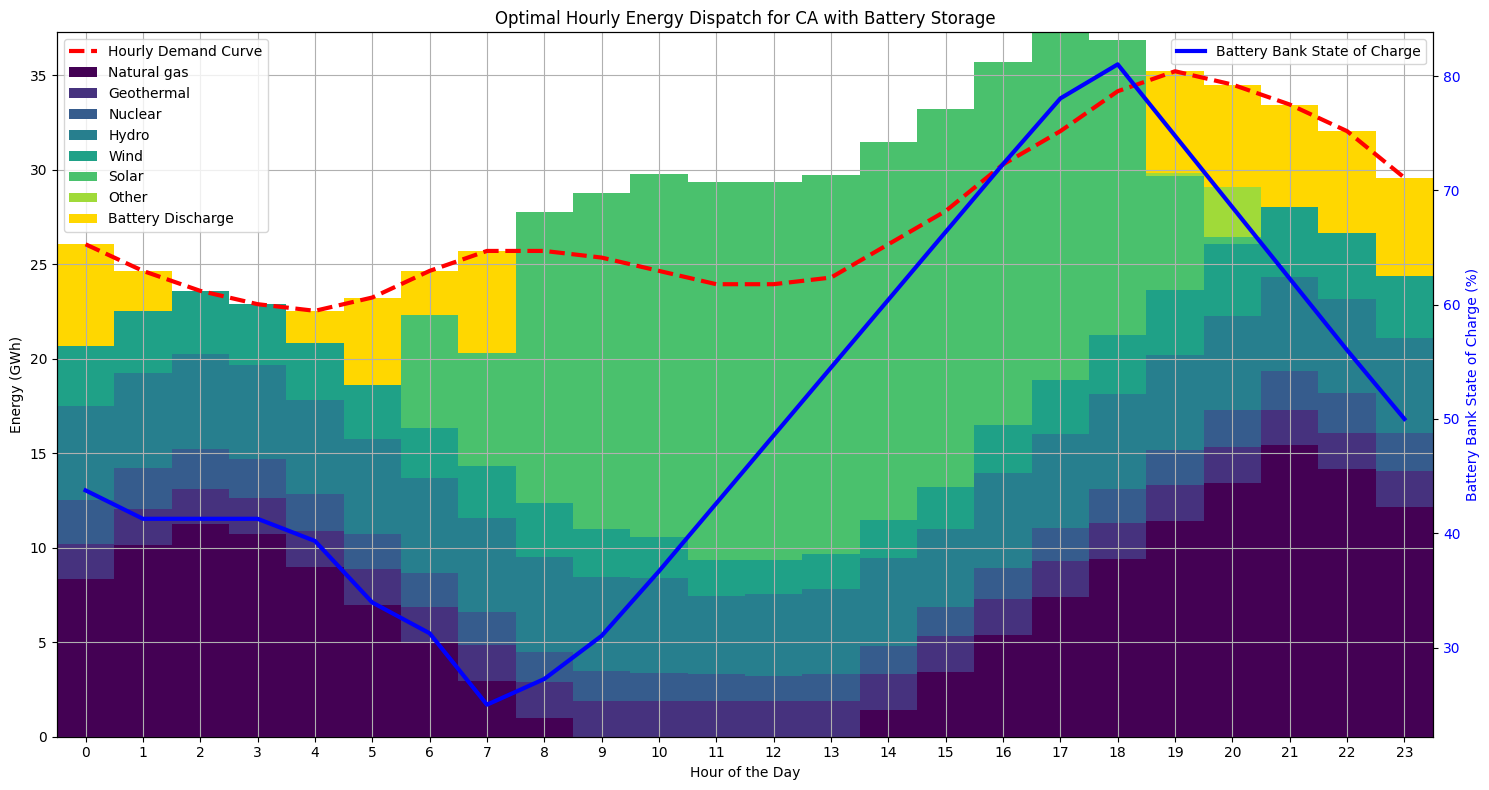

In [627]:
m = solve_with_capacity(INSTALLED_CAPACITY_MW)

natural gas    158,773  MWh
geothermal      45,600  MWh
nuclear         42,991  MWh
hydro          116,788  MWh
wind            67,662  MWh
solar          224,000  MWh
other            2,845  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,658  MWh
Total CO₂ emissions: 253,187 tonnes
Optimal daily cost: $25,729,992


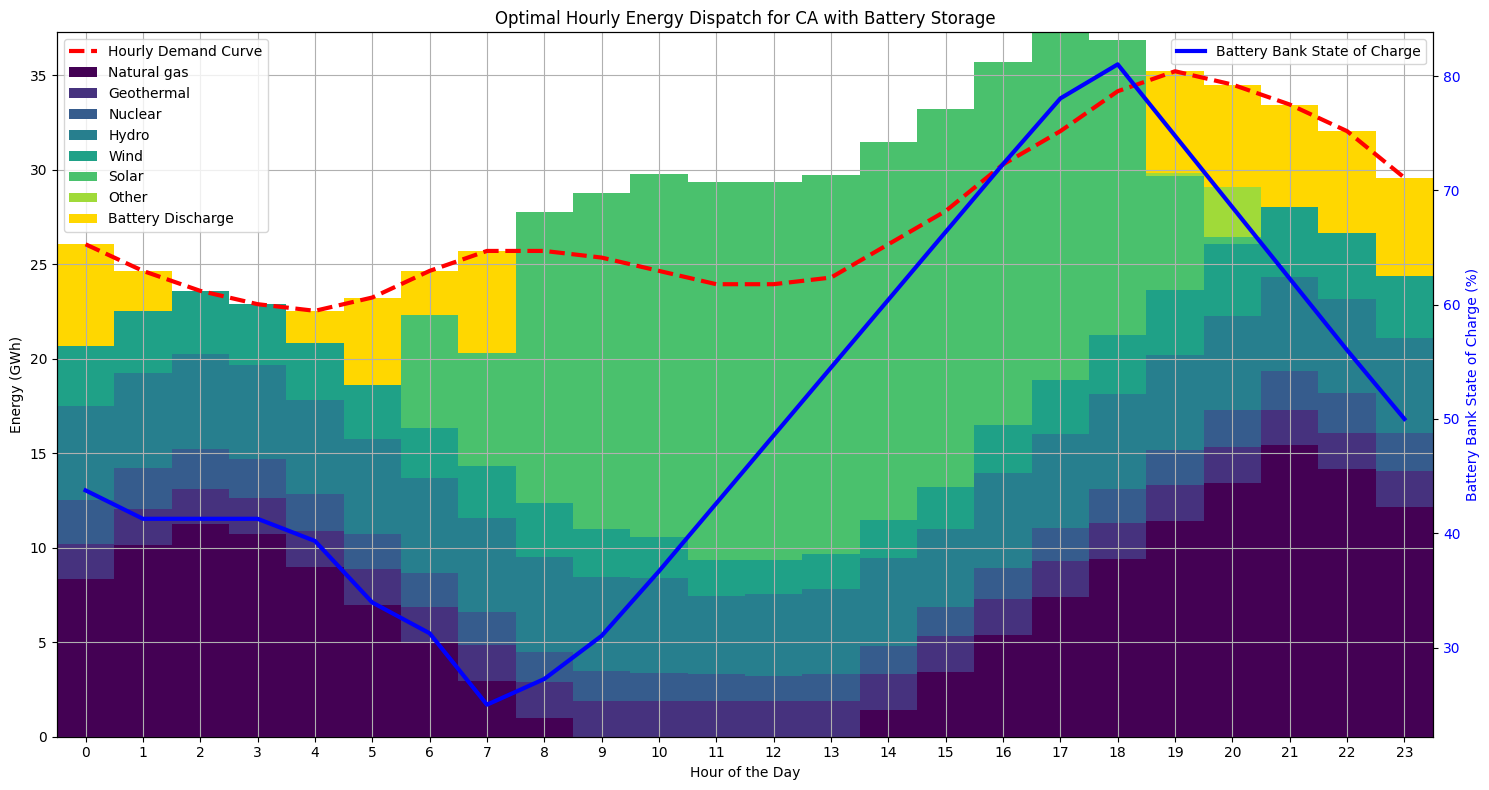

natural gas    156,402  MWh
geothermal      45,600  MWh
nuclear         32,135  MWh
hydro          115,390  MWh
wind            67,662  MWh
solar          235,200  MWh
other            6,269  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,658  MWh
Total CO₂ emissions: 250,029 tonnes
Optimal daily cost: $25,302,380


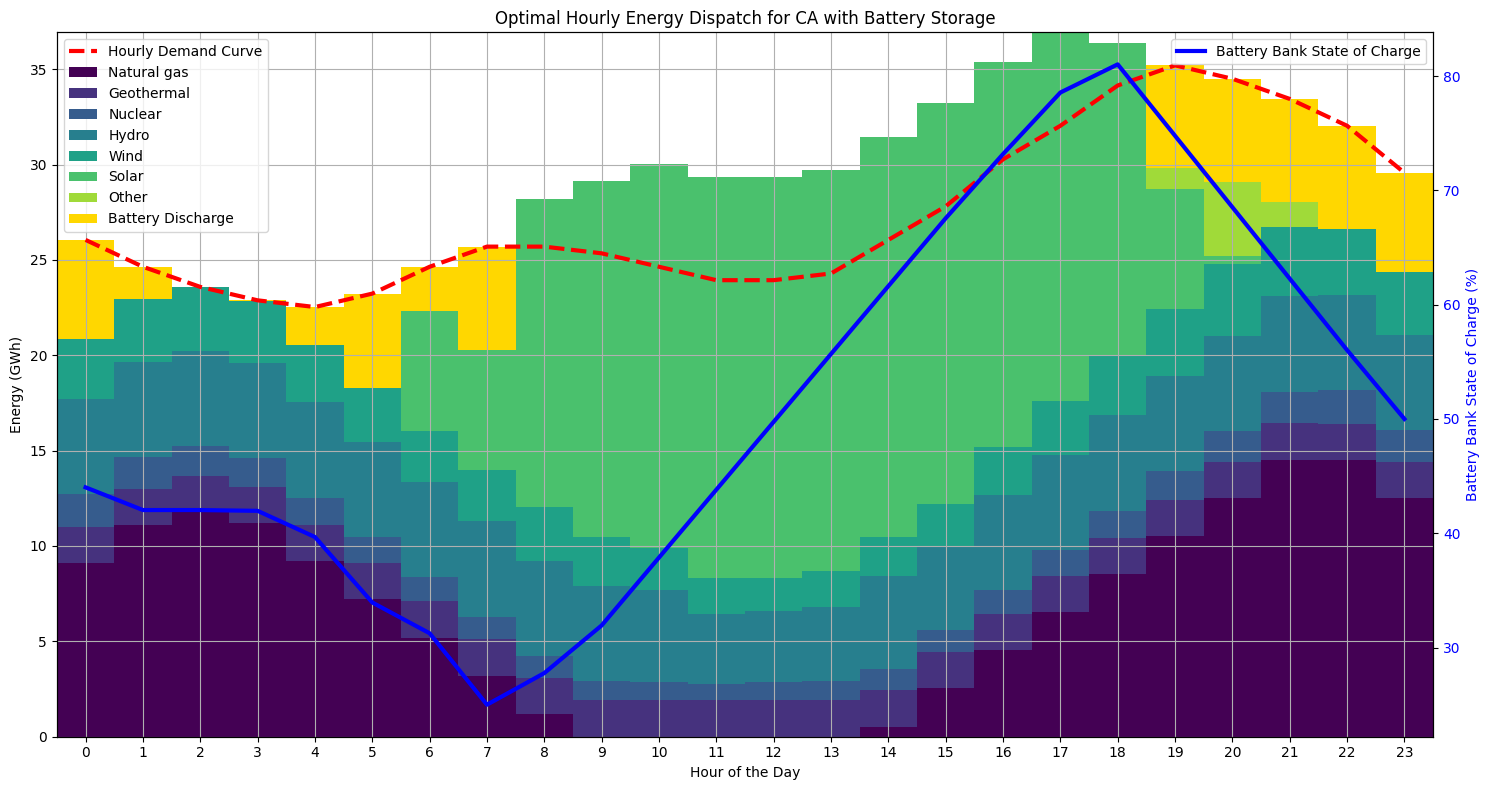

natural gas    154,080  MWh
geothermal      45,600  MWh
nuclear         21,898  MWh
hydro          113,396  MWh
wind            67,662  MWh
solar          246,400  MWh
other            9,623  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,658  MWh
Total CO₂ emissions: 246,935 tonnes
Optimal daily cost: $24,881,261


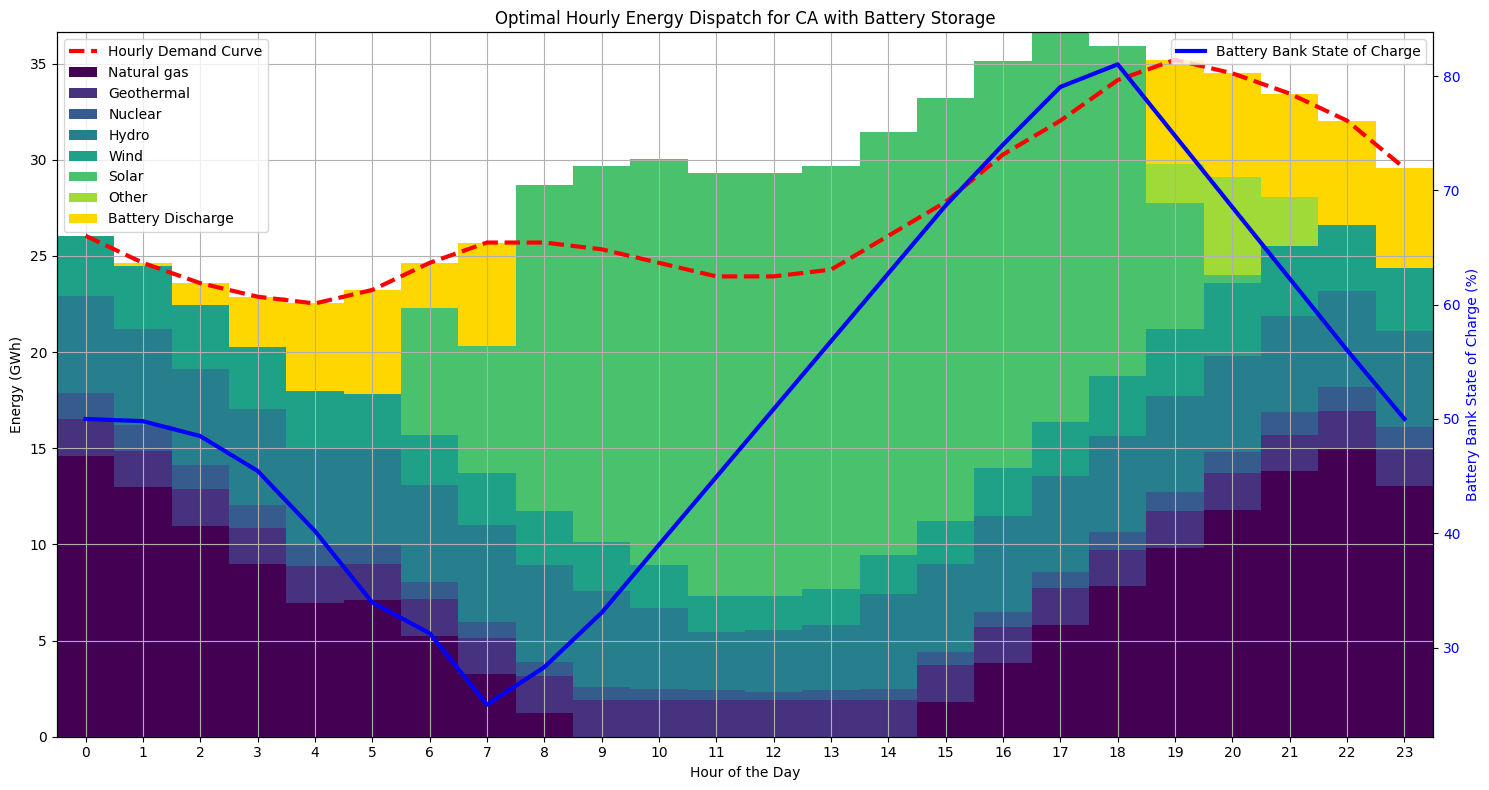

natural gas    151,646  MWh
geothermal      45,600  MWh
nuclear         12,233  MWh
hydro          110,668  MWh
wind            67,662  MWh
solar          257,600  MWh
other           13,259  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 243,665 tonnes
Optimal daily cost: $24,475,945


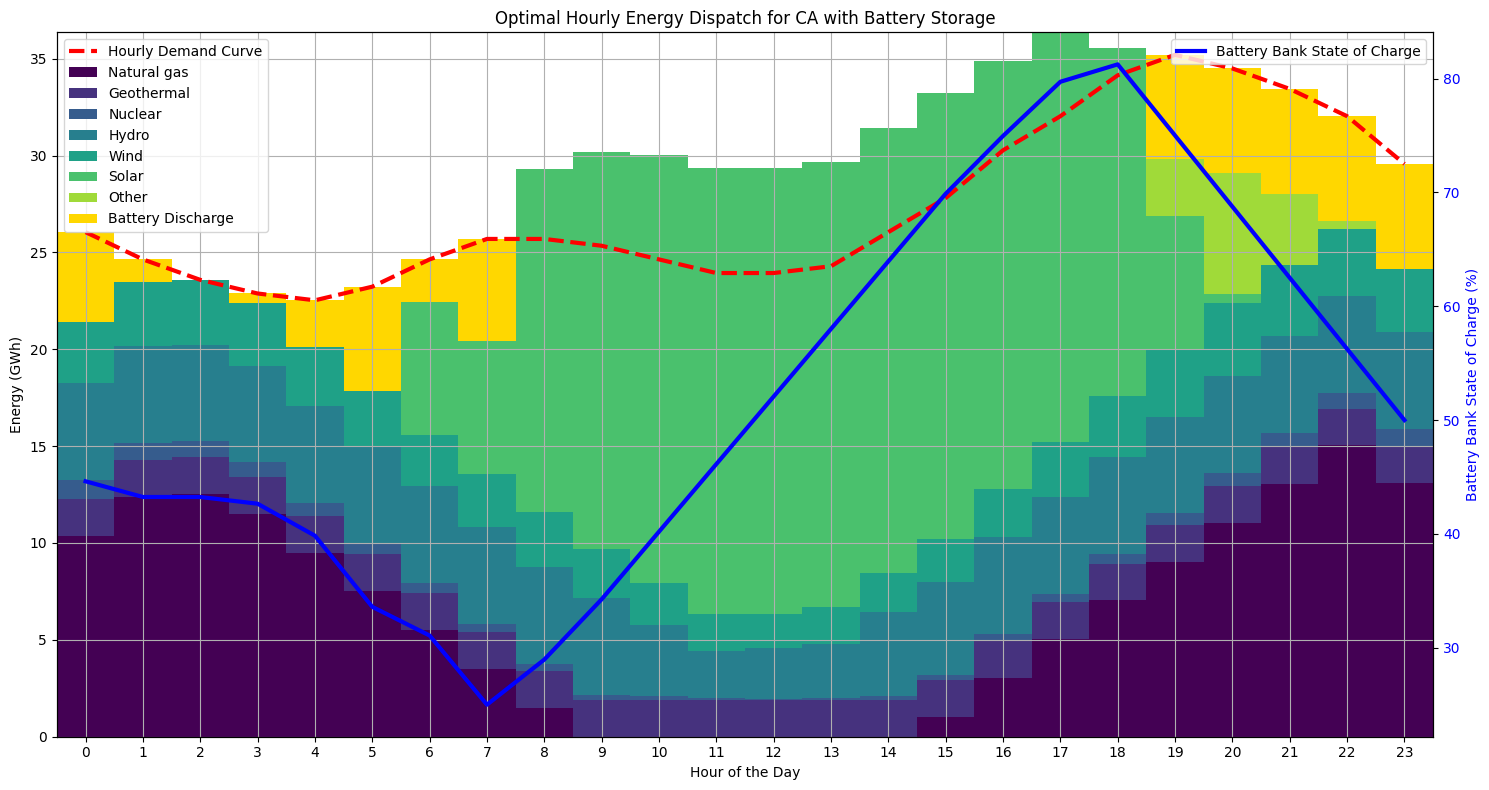

natural gas    150,846  MWh
geothermal      45,600  MWh
nuclear         10,560  MWh
hydro          101,534  MWh
wind            67,662  MWh
solar          268,800  MWh
other           13,667  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 242,771 tonnes
Optimal daily cost: $24,092,727


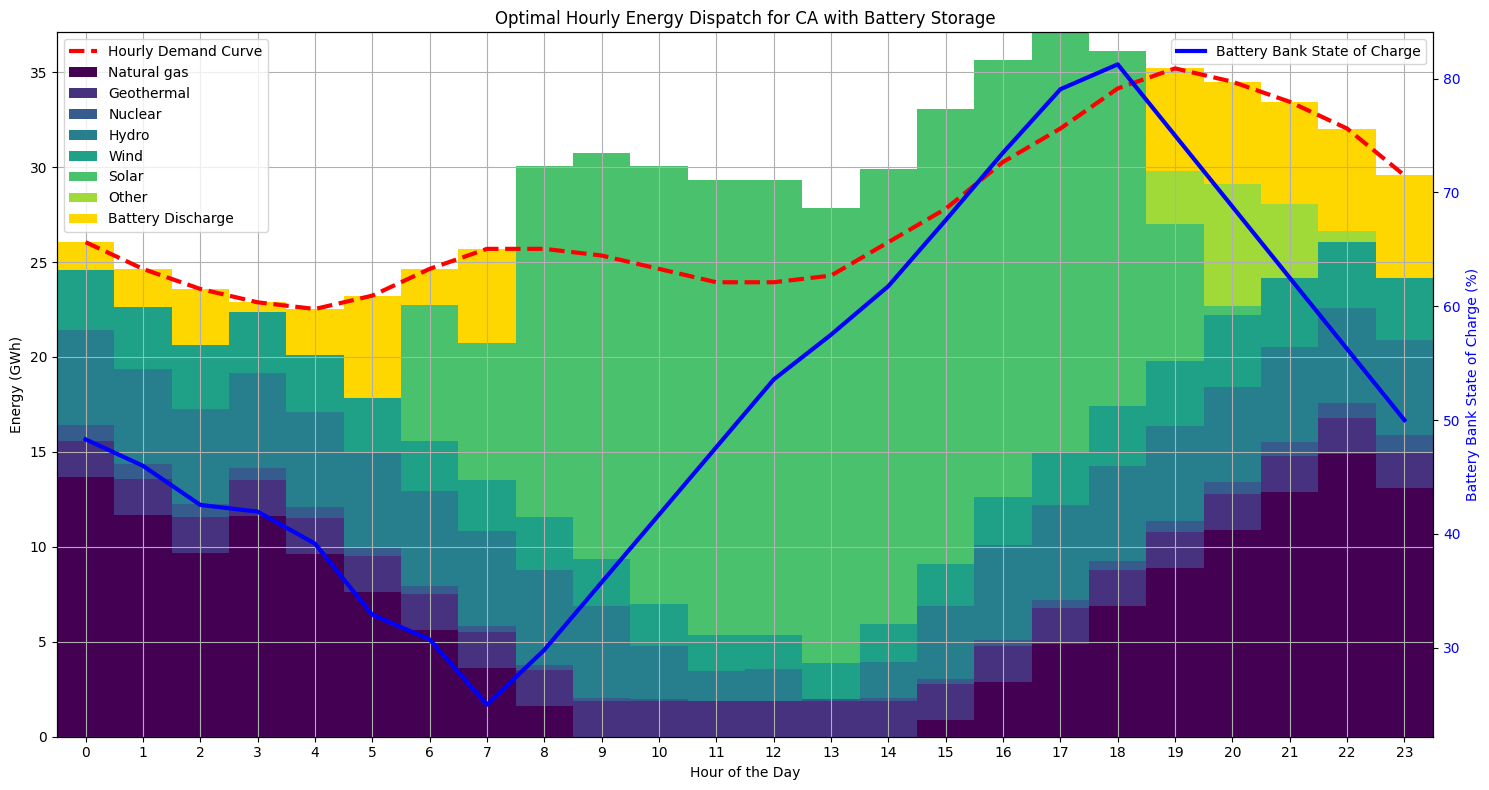

natural gas    150,457  MWh
geothermal      45,600  MWh
nuclear         10,560  MWh
hydro           91,148  MWh
wind            67,662  MWh
solar          280,000  MWh
other           13,241  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 242,480 tonnes
Optimal daily cost: $23,710,113


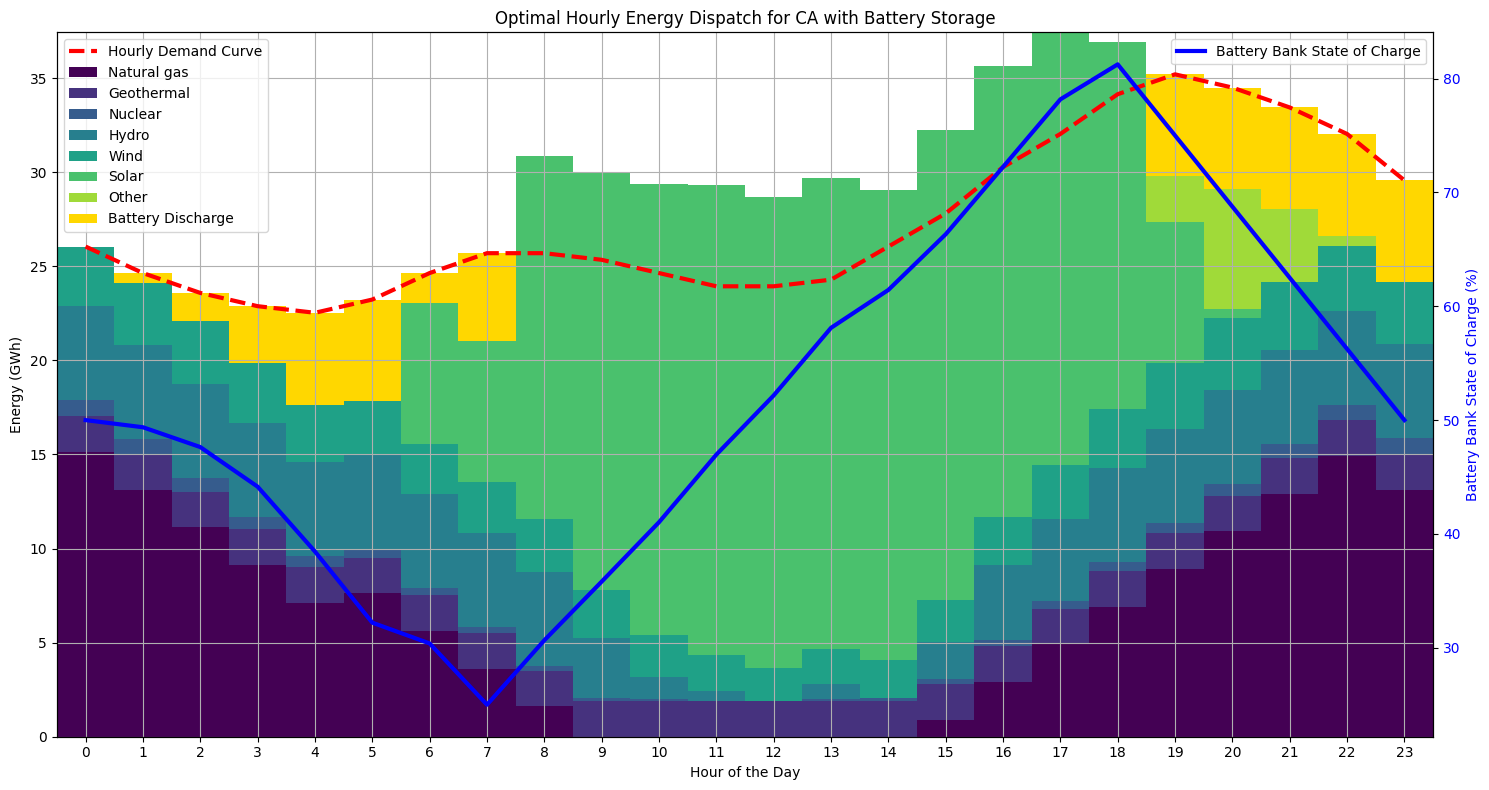

natural gas    149,869  MWh
geothermal      44,714  MWh
nuclear          9,680  MWh
hydro           82,268  MWh
wind            67,662  MWh
solar          291,200  MWh
other           13,275  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 241,884 tonnes
Optimal daily cost: $23,344,923


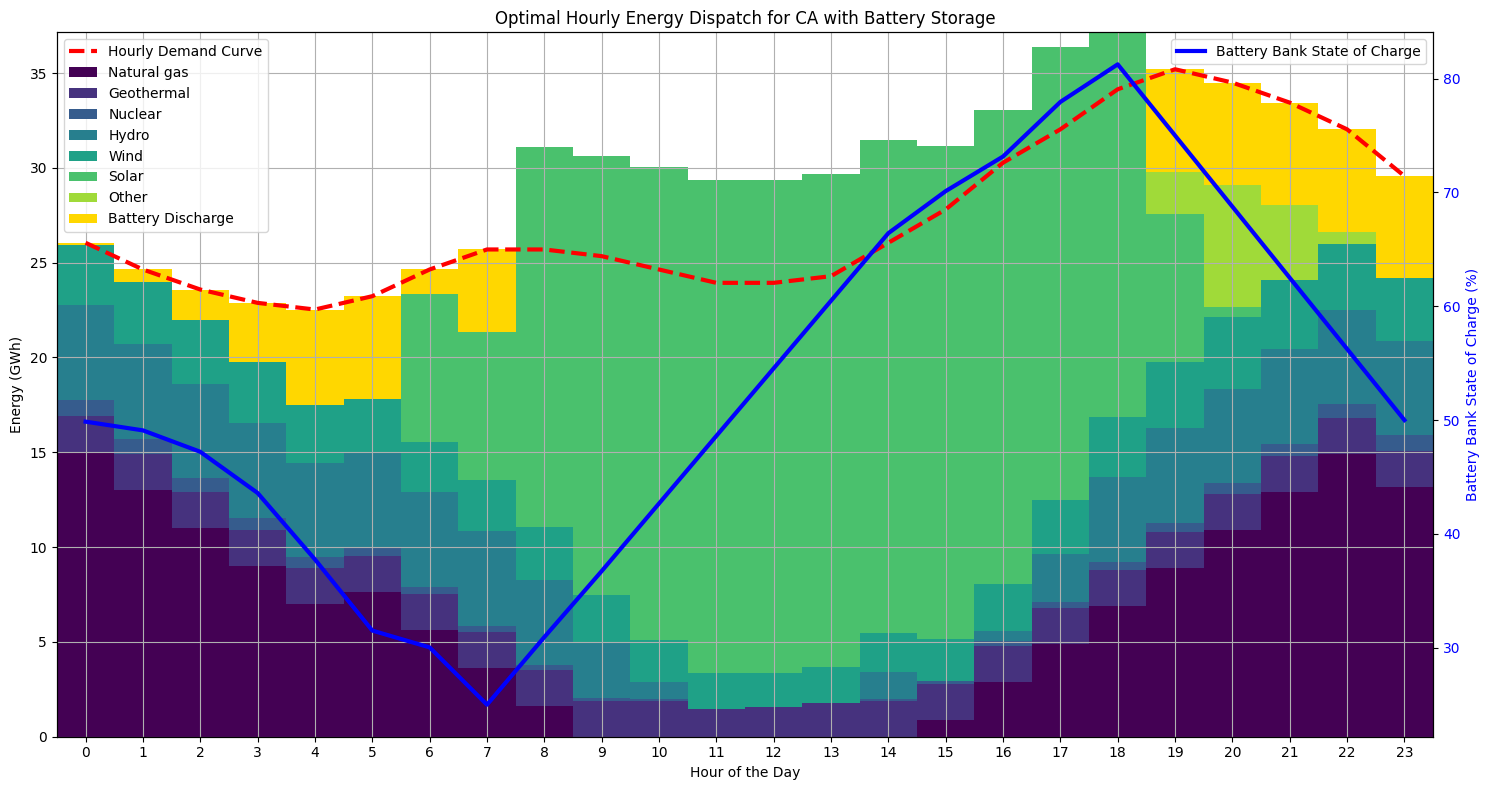

natural gas    149,405  MWh
geothermal      41,714  MWh
nuclear          8,958  MWh
hydro           75,347  MWh
wind            67,662  MWh
solar          302,400  MWh
other           13,183  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 241,441 tonnes
Optimal daily cost: $23,019,517


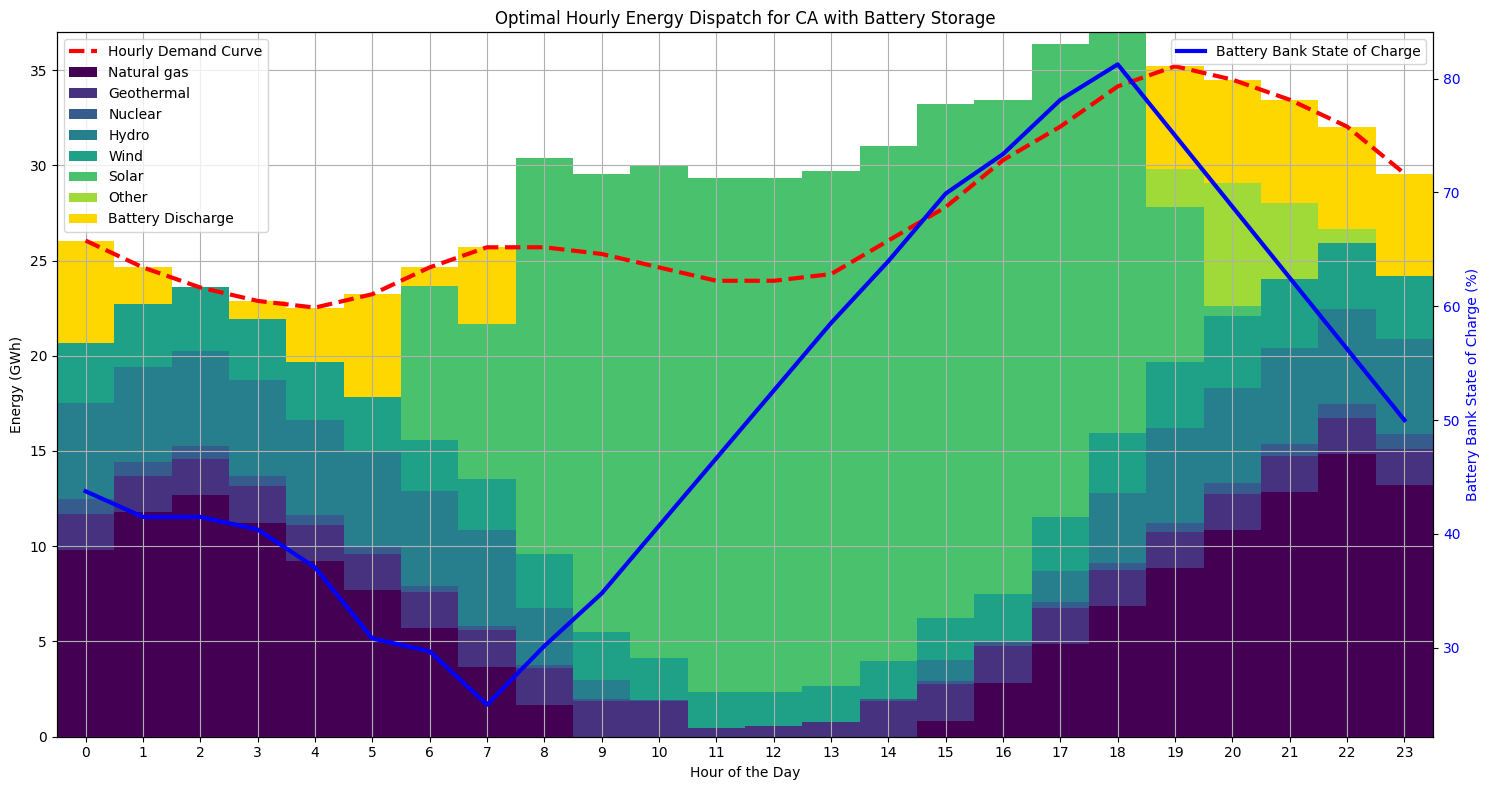

natural gas    147,423  MWh
geothermal      38,486  MWh
nuclear          3,491  MWh
hydro           73,000  MWh
wind            66,476  MWh
solar          313,600  MWh
other           16,193  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 238,767 tonnes
Optimal daily cost: $22,747,692


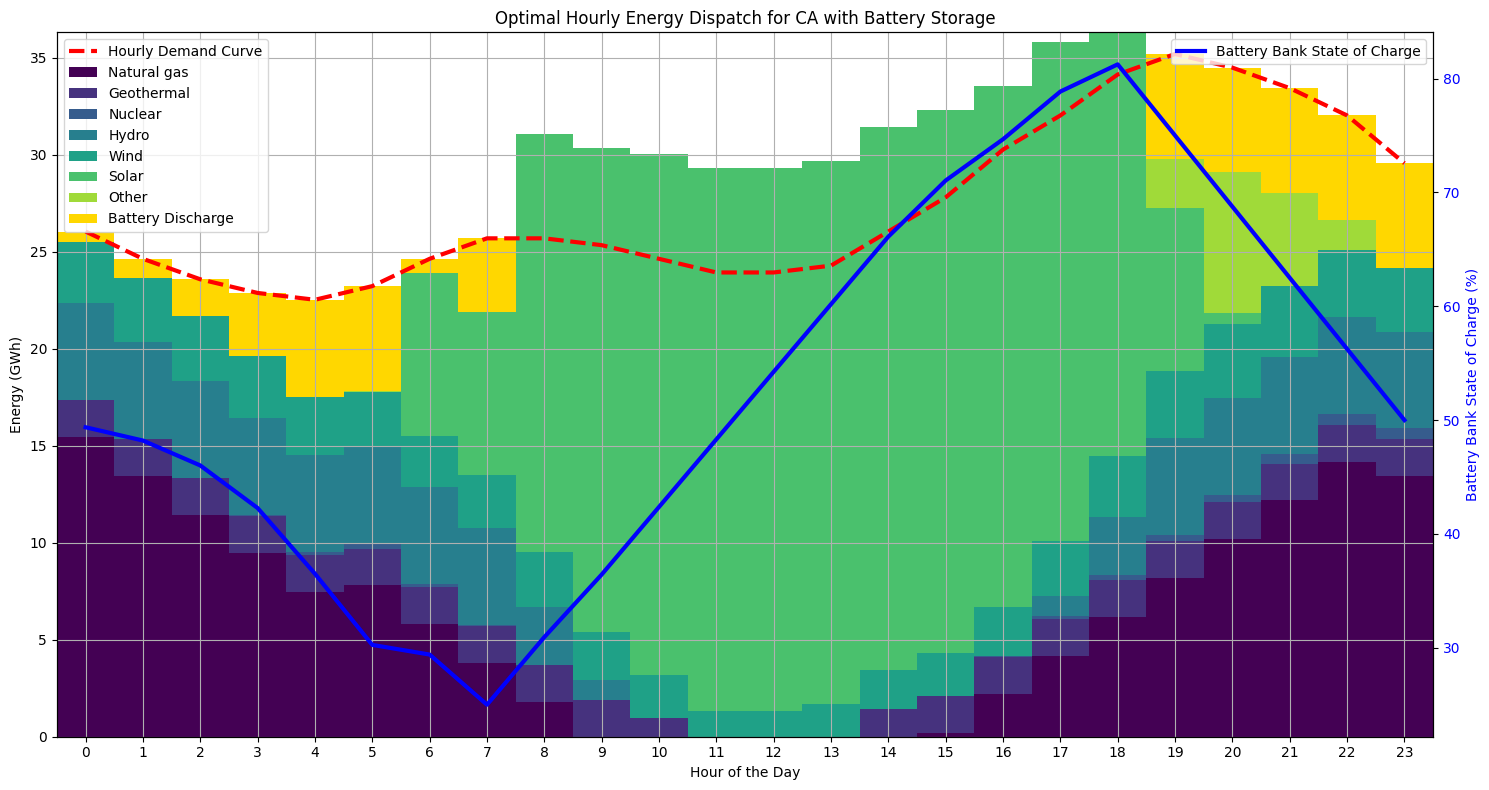

natural gas    145,955  MWh
geothermal      36,531  MWh
nuclear          2,800  MWh
hydro           66,986  MWh
wind            63,470  MWh
solar          324,800  MWh
other           18,126  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 236,855 tonnes
Optimal daily cost: $22,535,335


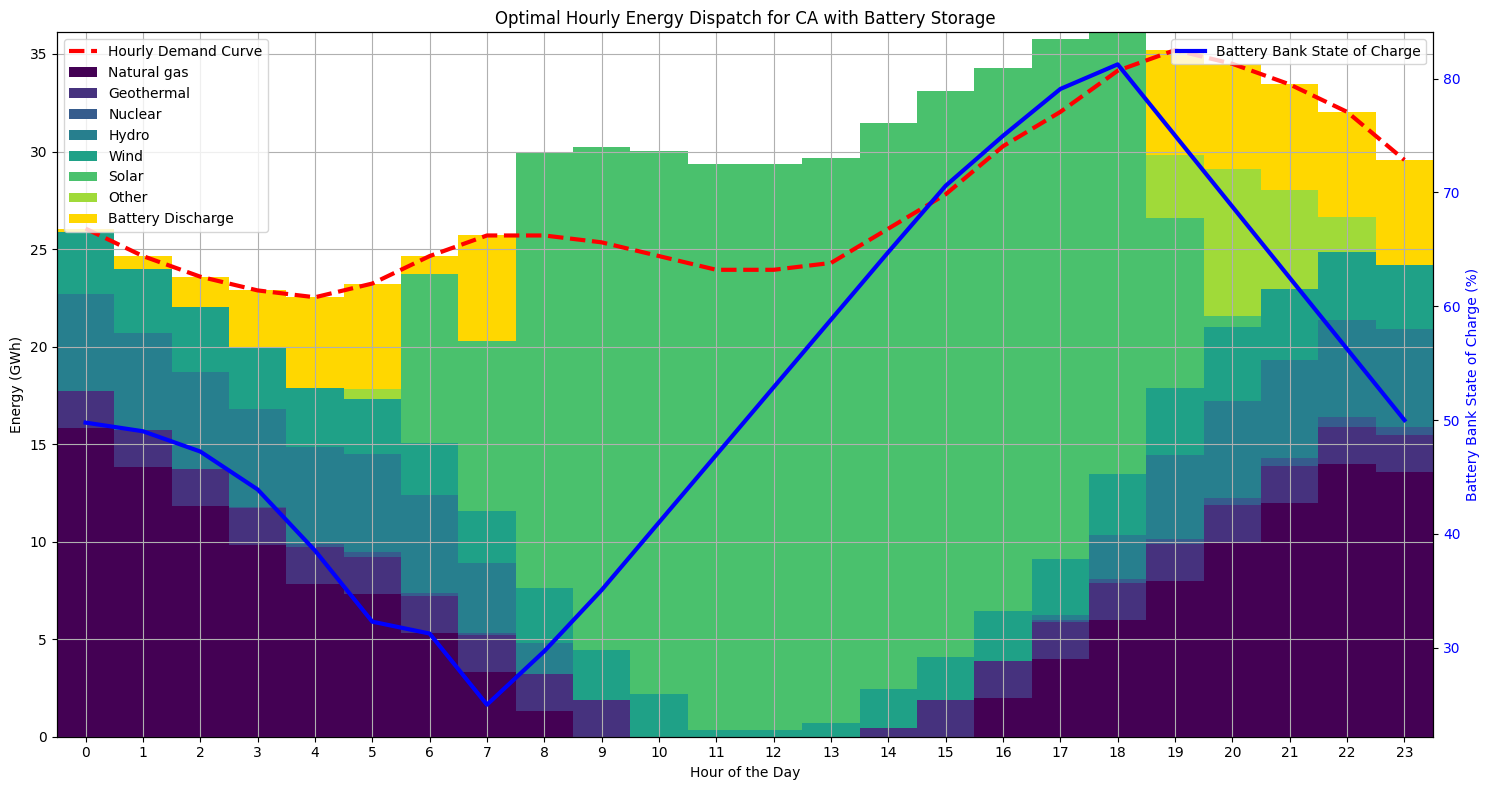

natural gas    145,385  MWh
geothermal      32,107  MWh
nuclear          2,800  MWh
hydro           65,000  MWh
wind            60,584  MWh
solar          334,358  MWh
other           18,436  MWh
Name: Energy (MWh), dtype: object

Total generation: 658,669  MWh
Total CO₂ emissions: 236,213 tonnes
Optimal daily cost: $22,388,631


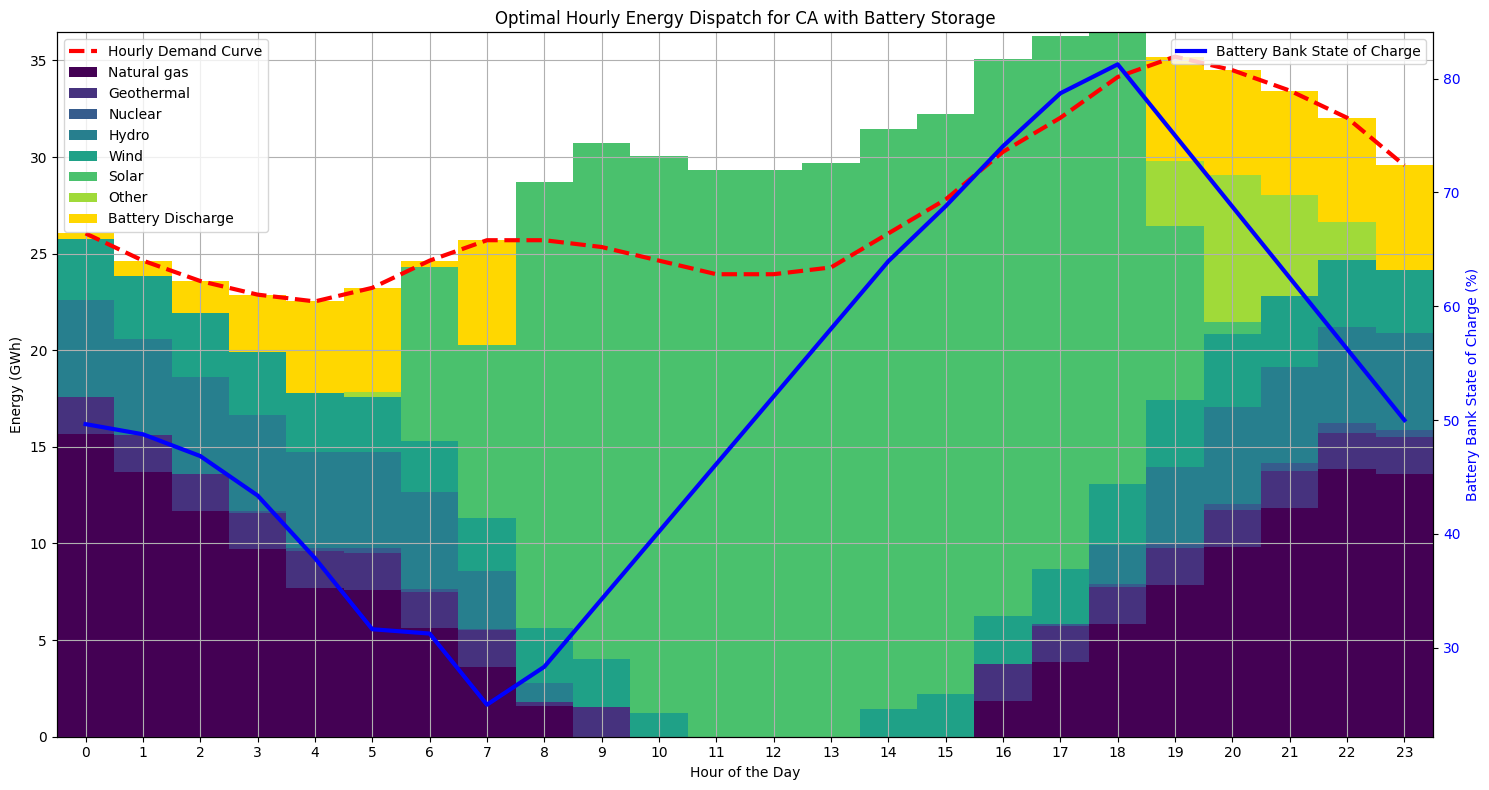

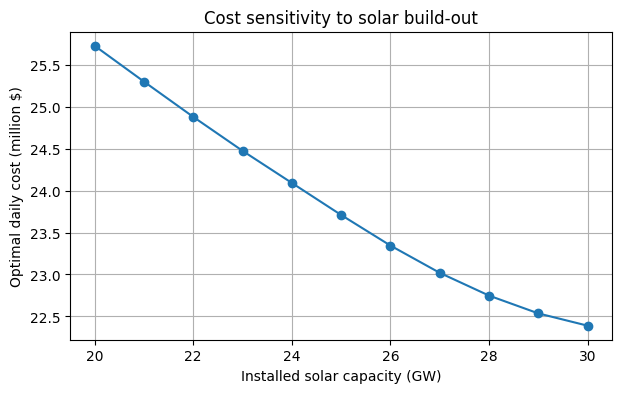

In [628]:
import copy

# sweep: base → base + 10,000 MW in 1 000 MW steps
base_solar = INSTALLED_CAPACITY_MW['solar']
sweep_MW   = np.arange(base_solar, base_solar + 11_000, 1_000)
opt_costs  = [solve_with_capacity({**INSTALLED_CAPACITY_MW, 'solar': mw}).ObjVal for mw in sweep_MW]

# plot
plt.figure(figsize=(7,4))
plt.plot(sweep_MW/1_000, np.array(opt_costs)/1e6, marker='o')
plt.xlabel('Installed solar capacity (GW)')
plt.ylabel('Optimal daily cost (million $)')
plt.title('Cost sensitivity to solar build-out')
plt.grid(True)
plt.show()

natural gas     90,158  MWh
geothermal      45,600  MWh
nuclear         54,720  MWh
hydro          115,128  MWh
wind            67,662  MWh
solar          224,000  MWh
other           60,689  MWh
Name: Energy (MWh), dtype: object

Total generation: 657,957  MWh
Total CO₂ emissions: 151,051 tonnes
Optimal daily cost: $74,852


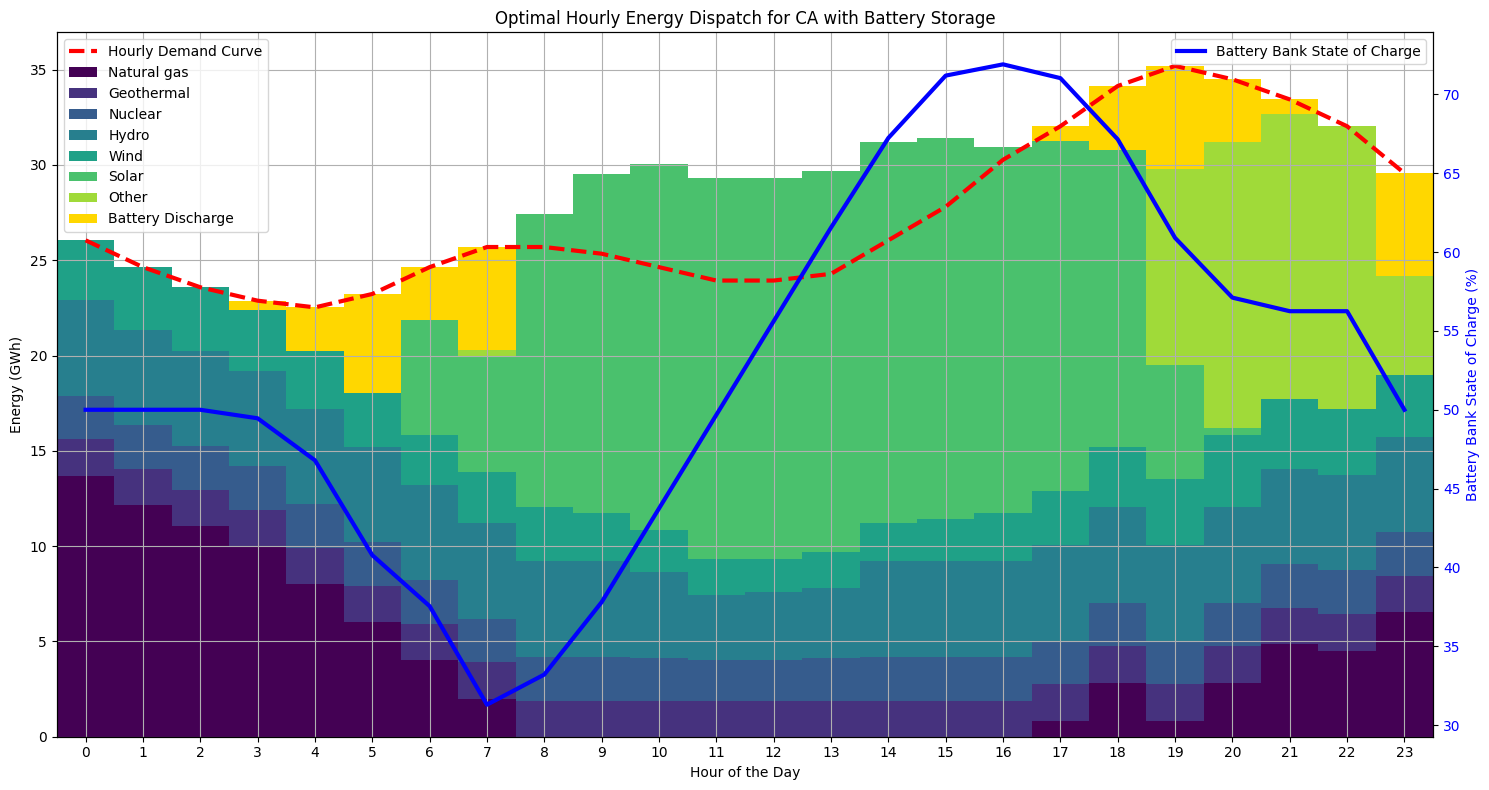

<gurobi.Model Continuous instance Hourly_Energy_Dispatch_with_Battery: 380 constrs, 240 vars, Parameter changes: Username=(user-defined), LicenseID=2678022, OutputFlag=0>

In [629]:
solve_with_capacity(INSTALLED_CAPACITY_MW, optimize_cost=False)

In [630]:
### --- OPTIMIZATION MODEL WITH BATTERIES --- ###

# Initialize the model
# Set up Gurobi environment
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

# Initialize the model
m = gp.Model(env=env, name="Hourly_Energy_Dispatch_with_Battery")

### DECISION VARIABLES ###

# generation[i, t]: kWh generated by fuel i in hour t
generation = m.addMVar((NUMFT, T), vtype=GRB.CONTINUOUS, name="generation")

# charge[t]: kWh sent TO the battery in hour t
charge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="charge")

# discharge[t]: kWh sent FROM the battery in hour t
discharge = m.addMVar(T, vtype=GRB.CONTINUOUS, ub=BATTERY_MAX_POWER_MW, name="discharge")

# soc[t]: State of Charge (energy in kWh) of the battery at the END of hour t
soc = m.addMVar(T, vtype=GRB.CONTINUOUS, lb=0, ub=BATTERY_MAX_ENERGY_MWH, name="soc")


### OBJECTIVE FUNCTION ###
# Minimize the total cost of generation over the 24-hour period
m.setObjective(gp.quicksum(generation[i, t] * C[i] for i in range(NUMFT) for t in range(T)), GRB.MINIMIZE)


### CONSTRAINTS ###

# 1. Hourly Demand Fulfillment Constraint
# For each hour, total generation + battery discharge - battery charge must equal demand.
m.addConstrs((generation.sum(axis=0)[t] + discharge[t] - charge[t] == HRLYDEMAND[t] for t in range(T)), name="DemandFulfillment")

# 2. Generation Capacity Constraint
# Each generator's output in an hour cannot exceed its installed capacity * its hourly capacity factor.
m.addConstrs((generation[i, t] <= INSTALLED_CAPACITY_MW_array[i] * HRLY_CAP_FACTORS.loc[FUEL[i], t] for i in range(NUMFT) for t in range(T)), name="GenCapacity")

# 3. Total CO2 Emissions Constraint
# Sum of all emissions over 24 hours must be below the daily limit.
m.addConstr(gp.quicksum(generation[i, t] * E[i] for i in range(NUMFT) for t in range(T)) <= daily_co2_limit, name="CO2_Limit")

# --- BATTERY CONSTRAINTS ---

# 4. Battery State of Charge (SoC) Evolution
# This is the key constraint linking time periods.
# SoC at end of hour t = SoC at end of hour t-1 + energy charged - energy discharged.
m.addConstr(soc[0] == BATTERY_INITIAL_SOC_MWH + charge[0] * BATTERY_CHARGE_EFFICIENCY - discharge[0], name="SoC_Initial")
m.addConstrs((soc[t] == soc[t-1] + charge[t] * BATTERY_CHARGE_EFFICIENCY - discharge[t] for t in range(1, T)), name="SoC_Evolution")

# 5. Cyclic Constraint
# Ensure the battery has at least as much energy at the end of the day as it started with.
m.addConstr(soc[T-1] >= BATTERY_INITIAL_SOC_MWH, name="CyclicSoC")

# ------------------------------------------------------------------
# 1.  Set up max-change-per-hour limits (MW) for each fuel type
# ------------------------------------------------------------------
RAMP_LIMIT = {           # MW change allowed in either direction
    "natural gas":    2000,
    "nuclear": 80,
    "hydro":   2000,
    # Solar and Wind omitted → no restriction
}

# Convenience: look up the ramp limit by the unit’s fuel name
limit = [RAMP_LIMIT.get(FUEL[i], None)   # None ⇒ unrestricted
        for i in range(NUMFT)]

# ------------------------------------------------------------------
# 2.  Add the ramp-rate constraints
# ------------------------------------------------------------------
for i in range(NUMFT):
    if limit[i] is None:          # skip Solar, Wind, etc.
        continue
    for t in range(1, T):         # start at t = 1 so t-1 exists
        m.addConstr(
            generation[i, t] - generation[i, t-1] <=  limit[i],
            name=f"RampUp_{FUEL[i]}_{t}")
        m.addConstr(
            generation[i, t-1] - generation[i, t] <=  limit[i],
            name=f"RampDn_{FUEL[i]}_{t}")

m.optimize()
for t in hours:
    m.getVarByName('soc['+str(t)+']').setAttr('ub', 0)
m.getConstrByName('SoC_Initial').setAttr('RHS',0)
m.getConstrByName('CyclicSoC').setAttr('RHS',0)
m.update()
m.optimize()
# 1️⃣  pull the solution → sum across the 24 hours (axis=1)
energy_MWh = generation.X.sum(axis=1)             # shape = (NUMFT,)

# 2️⃣  make a tidy Series keyed by fuel name
by_source = pd.Series(energy_MWh, index=FUEL, name="Energy (MWh)")

# 3️⃣  print neatly ────────────────
print(by_source.apply(lambda x: f"{x:,.0f}  MWh"))
print("\nTotal generation:", f"{by_source.sum():,.0f}  MWh")
by_fuel     = pd.Series(energy_MWh, index=FUEL)

# --- 3. compute & print total emissions ---------------------------
emissions_tonnes = (by_fuel * by_fuel.index.map(EMISSION_FACTORS)).sum()
print(f"Total CO₂ emissions: {emissions_tonnes:,.0f} tonnes")


natural gas    136,450  MWh
geothermal      41,208  MWh
nuclear         48,720  MWh
hydro           83,800  MWh
wind            67,662  MWh
solar          224,000  MWh
other           54,270  MWh
Name: Energy (MWh), dtype: object

Total generation: 656,111  MWh
Total CO₂ emissions: 219,037 tonnes


Optimal daily cost: $27,103,023


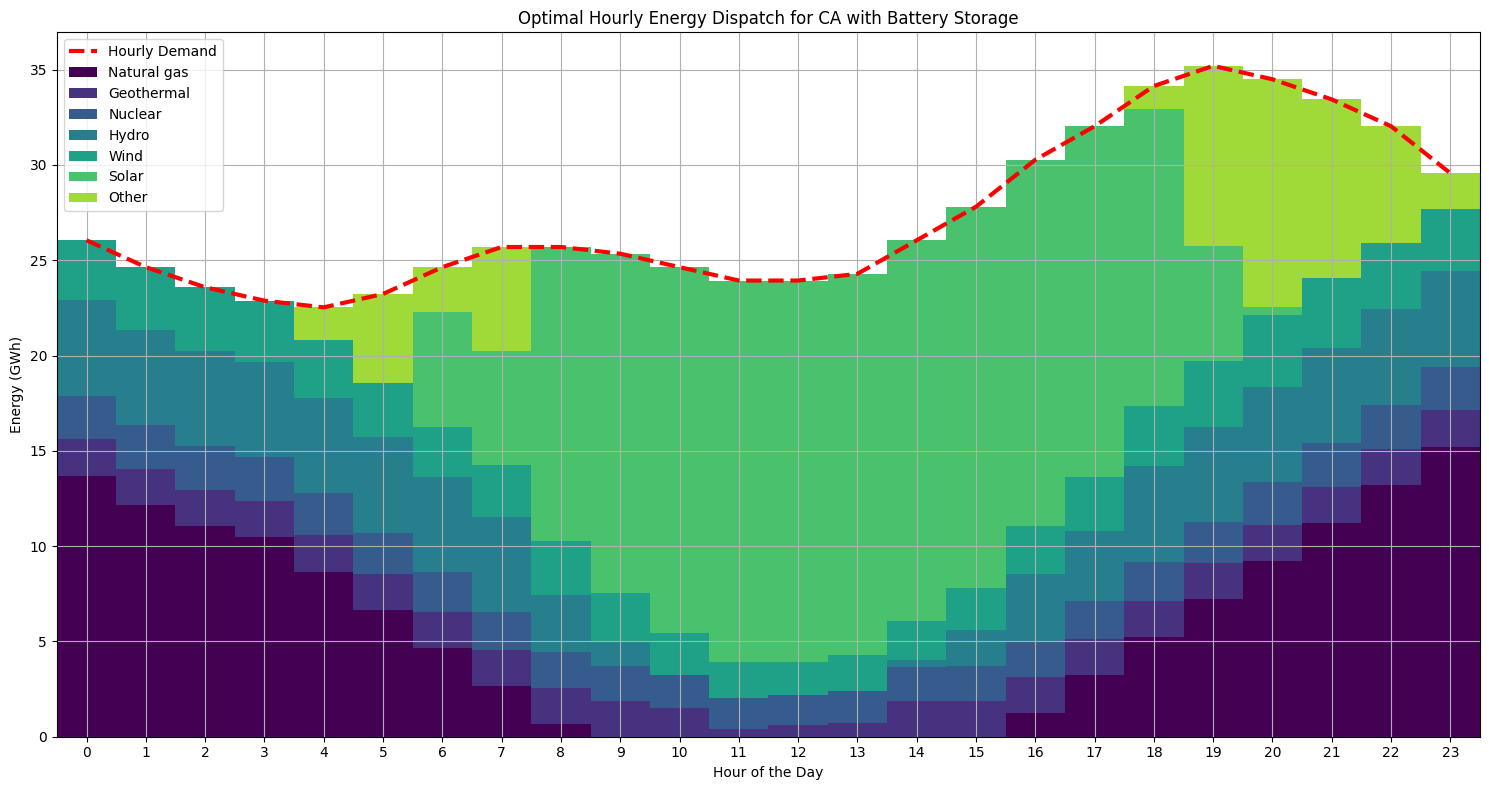

In [631]:
### VISUALIZE THE RESULTS ###

if m.Status == GRB.OPTIMAL:
    print(f"Optimal daily cost: ${m.ObjVal:,.0f}")

    # Extract solution data, convert MWh to GWh
    gen_sol = pd.DataFrame(generation.X, index=FUEL, columns=hours)/1e3

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Plot net demand (the duck curve)
    ax1.plot(hours, HRLYDEMAND/1e3, 'r--', linewidth=3, label='Hourly Demand')

    # Stacked bar chart for generation
    bottom = np.zeros(T)
    colors = plt.cm.viridis(np.linspace(0, 1, NUMFT+1))
    for i, fuel in enumerate(FUEL):
        ax1.bar(hours, gen_sol.loc[fuel], bottom=bottom, label=fuel.capitalize(), color=colors[i], width=1.0)
        bottom += gen_sol.loc[fuel]

    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Energy (GWh)')
    ax1.set_title(f'Optimal Hourly Energy Dispatch for {state} with Battery Storage')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    ax1.set_xticks(hours)
    ax1.set_xlim(-0.5, 23.5)
    
    fig.tight_layout()
    plt.show()

else:
    print("Optimization was not successful. Status:", m.Status)